### Set Up

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


In [2]:
rides = pd.read_parquet("output/rides/part-00000-bbe7aca0-61f1-4f7b-bdf9-a7efdd66c11f-c000.snappy.parquet")
rides.to_csv("rides.csv", index=False)
print(rides.columns)
rides.head()

Index(['event_id', 'ride_id', 'event_type', 'timestamp', 'user_id',
       'driver_id', 'pickup_latitude', 'pickup_longitude', 'pickup_address',
       'pickup_city', 'dropoff_latitude', 'dropoff_longitude',
       'dropoff_address', 'dropoff_city', 'distance_km',
       'estimated_duration_minutes', 'actual_duration_minutes', 'vehicle_type',
       'base_fare', 'surge_multiplier', 'total_fare', 'payment_method',
       'payment_status', 'payment_id', 'user_to_driver_rating',
       'driver_to_user_rating', 'user_comment', 'driver_comment',
       'canceled_by', 'cancellation_reason', 'cancellation_fee',
       'traffic_level', 'estimated_delay_minutes', 'driver_latitude',
       'driver_longitude', 'driver_heading', 'driver_speed_kmh', 'app_version',
       'platform', 'session_id'],
      dtype='object')


,event_id,ride_id,event_type,timestamp,user_id,driver_id,pickup_latitude,pickup_longitude,pickup_address,pickup_city,...,cancellation_fee,traffic_level,estimated_delay_minutes,driver_latitude,driver_longitude,driver_heading,driver_speed_kmh,app_version,platform,session_id
0,580c1c25ec24_5,R-7ab1d1b6fd,RIDE_COMPLETED,2025-01-01 08:11:15.778,U000205,D000090,40.408460,-3.702370,6528 Calle de Argumosa,Madrid,...,NaN,HIGH,26,40.498333,-3.567498,309.957733,0.000000,4.7.0,iOS,S-884574d4
1,a6f88d2bd2a9_3,R-8f0317bd51,DRIVER_ARRIVED,2025-01-01 07:22:13.399,U000071,D000071,40.461591,-3.676449,1314 Calle de Padre Damián,Madrid,...,NaN,SEVERE,31,40.461591,-3.676449,310.453857,0.000000,4.6.0,iOS,S-0db1fb52
2,9e531ddbb954_1,R-9f0cfbb2b9,RIDE_REQUESTED,2025-01-01 07:37:28.079,U000097,None,40.416757,-3.703749,5935 Calle Gran Via,Madrid,...,NaN,SEVERE,46,NaN,NaN,NaN,NaN,4.6.0,Android,S-c892e1bb
3,9e531ddbb954_2,R-9f0cfbb2b9,DRIVER_ASSIGNED,2025-01-01 07:37:39.756,U000097,D000078,40.416757,-3.703749,5935 Calle Gran Via,Madrid,...,NaN,SEVERE,46,40.400801,-3.700461,247.237595,38.600246,4.6.0,Android,S-c892e1bb
4,9e531ddbb954_5,R-9f0cfbb2b9,RIDE_COMPLETED,2025-01-01 07:51:05.103,U000097,D000078,40.416757,-3.703749,5935 Calle Gran Via,Madrid,...,NaN,SEVERE,46,40.416664,-3.703755,325.456879,0.000000,4.6.0,Android,S-c892e1bb


In [3]:
special = pd.read_parquet("output\specials\part-00001-ddcf2c16-9f59-43db-93aa-d942715d5770-c000.snappy.parquet")
special.to_csv("special.csv", index=False)
print(special.columns)
special.head()

Index(['event_type', 'event_name', 'venue_zone', 'venue_latitude',
       'venue_longitude', 'venue_address', 'venue_city', 'event_start',
       'event_end', 'arrivals_start', 'arrivals_end', 'departures_start',
       'departures_end', 'arrival_rides', 'departure_rides',
       'estimated_attendees'],
      dtype='object')


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\3010379486.py:1: SyntaxWarning: invalid escape sequence '\s'
  special = pd.read_parquet("output\specials\part-00001-ddcf2c16-9f59-43db-93aa-d942715d5770-c000.snappy.parquet")


,event_type,event_name,venue_zone,venue_latitude,venue_longitude,venue_address,venue_city,event_start,event_end,arrivals_start,arrivals_end,departures_start,departures_end,arrival_rides,departure_rides,estimated_attendees
0,concert,Concert Event 1,retiro,40.414600,-3.6868,795 Retiro Calle,Madrid,2025-01-01 19:00:00,2025-01-01 22:00:00,2025-01-01 16:00:00,2025-01-01 19:15:00,2025-01-01 21:30:00,2025-01-02 00:00:00,1079,1214,5200
1,concert,Concert Event 2,airport,40.498299,-3.5676,598 Airport Calle,Madrid,2025-01-01 19:00:00,2025-01-01 22:00:00,2025-01-01 16:00:00,2025-01-01 19:15:00,2025-01-01 21:30:00,2025-01-02 00:00:00,2090,2351,8004
2,concert,Concert Event 1,retiro,40.414600,-3.6868,795 Retiro Calle,Madrid,2025-01-01 19:00:00,2025-01-01 22:00:00,2025-01-01 16:00:00,2025-01-01 19:15:00,2025-01-01 21:30:00,2025-01-02 00:00:00,1079,1214,5200
3,concert,Concert Event 2,airport,40.498299,-3.5676,598 Airport Calle,Madrid,2025-01-01 19:00:00,2025-01-01 22:00:00,2025-01-01 16:00:00,2025-01-01 19:15:00,2025-01-01 21:30:00,2025-01-02 00:00:00,2090,2351,8004
4,sports,Atlético de Madrid vs Sevilla FC Game,malasana,40.426498,-3.7025,301 Sports Stadium,Madrid,2025-01-01 16:00:00,2025-01-01 19:00:00,2025-01-01 14:00:00,2025-01-01 16:15:00,2025-01-01 18:45:00,2025-01-01 20:30:00,3113,4003,37080


In [4]:
# Function to map levels to indices
def map_level(level, dictionary):
    if level in dictionary:
        return dictionary[level]
    else:
        # Return the next index after known categories as the "other" category
        return len(dictionary)

### Creating User Profiles

#### Determining if Special Events' Rides

In [5]:
latitude_adjustment = 0.00449 # Equivalent to 0.5km
longitude_adjustment = 0.0059 # Equivalent to 0.5km
loc_spec_lat = special.iloc[0]["venue_latitude"]
loc_spec_lon = special.iloc[0]["venue_longitude"]

lat_interval = [loc_spec_lat - latitude_adjustment, loc_spec_lat + latitude_adjustment]
lon_interval = [loc_spec_lon - longitude_adjustment, loc_spec_lon + longitude_adjustment]


for row in rides.iterrows():
    if row[1]["pickup_latitude"] >= lat_interval[0] and row[1]["pickup_latitude"] <= lat_interval[1] and row[1]["pickup_longitude"] >= lon_interval[0] and row[1]["pickup_longitude"] <= lon_interval[1]:
        print("Leaving -> ride id: ", row[0])
    elif row[1]["dropoff_latitude"] >= lat_interval[0] and row[1]["dropoff_latitude"] <= lat_interval[1] and row[1]["dropoff_longitude"] >= lon_interval[0] and row[1]["dropoff_longitude"] <= lon_interval[1]:
        print("Coming -> ride id: ", row[0])



Coming -> ride id:  8
Coming -> ride id:  9
Coming -> ride id:  10
Coming -> ride id:  23
Coming -> ride id:  24
Coming -> ride id:  25
Coming -> ride id:  28
Coming -> ride id:  38
Coming -> ride id:  39
Coming -> ride id:  40
Leaving -> ride id:  44
Leaving -> ride id:  45
Leaving -> ride id:  46
Leaving -> ride id:  47
Coming -> ride id:  71
Coming -> ride id:  72
Leaving -> ride id:  73
Leaving -> ride id:  87
Leaving -> ride id:  92
Leaving -> ride id:  93
Leaving -> ride id:  94
Leaving -> ride id:  103
Leaving -> ride id:  115
Leaving -> ride id:  143
Coming -> ride id:  152
Coming -> ride id:  153
Coming -> ride id:  154
Coming -> ride id:  157


In [6]:
# Function to check if a point is within the defined area
def is_within_area(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return False
    return (lat_interval[0] <= lat <= lat_interval[1] and 
            lon_interval[0] <= lon <= lon_interval[1])

def determine_ride_direction(row, venue_lat, venue_lon, distance_km=0.5):
    """
    Determines if a ride is coming to, leaving from, or unrelated to a venue.
    
    Parameters:
    - row: A row from the rides dataframe
    - venue_lat: Latitude of the venue
    - venue_lon: Longitude of the venue
    - distance_km: Distance threshold in kilometers
    
    Returns:
    - 'coming', 'leaving', or None
    """
    # Constants for latitude/longitude adjustments
    latitude_adjustment = 0.009898 * distance_km
    longitude_adjustment = 0.00118 * distance_km
    
    # Define intervals around the venue
    lat_interval = [venue_lat - latitude_adjustment, venue_lat + latitude_adjustment]
    lon_interval = [venue_lon - longitude_adjustment, venue_lon + longitude_adjustment]
    
    # Check if pickup/dropoff locations are within the area
    def is_within_area(lat, lon):
        if pd.isna(lat) or pd.isna(lon):
            return False
        return (lat_interval[0] <= lat <= lat_interval[1] and 
                lon_interval[0] <= lon <= lon_interval[1])
    
    pickup_in_area = is_within_area(row["pickup_latitude"], row["pickup_longitude"])
    dropoff_in_area = is_within_area(row["dropoff_latitude"], row["dropoff_longitude"])
    
    if pickup_in_area and not dropoff_in_area:
        return 'leaving'
    elif not pickup_in_area and dropoff_in_area:
        return 'coming'
    else:
        return None


In [7]:
a = determine_ride_direction(rides.iloc[72], loc_spec_lat, loc_spec_lon)
print(a)

coming


In [8]:
def analyze_rides_for_all_events(rides_df, special_df, distance_km=0.5):
    """
    Creates two new columns in the rides dataframe:
    1. 'event_direction': indicates if a ride was coming to, leaving from, or unrelated to any event
    2. 'event_name': indicates which event the ride was related to, if any
    
    Parameters:
    - rides_df: DataFrame containing ride data
    - special_df: DataFrame containing special event data
    - distance_km: Distance threshold in kilometers
    
    Returns:
    - rides_df with two new columns
    """
    # Create a dictionary of unique events with their coordinates
    # Use event_name as key and (lat, lon) as value
    events_dict = {}
    
    # Drop duplicates to get unique events (based on name, latitude, and longitude)
    unique_events = special_df.drop_duplicates(subset=['event_name', 'venue_latitude', 'venue_longitude', 'event_type'])
    
    for _, event in unique_events.iterrows():
        event_type = event['event_type']
        lat = event['venue_latitude']
        lon = event['venue_longitude']
        events_dict[event_type] = (lat, lon)
    
    # Initialize new columns
    rides_df['event_direction'] = None
    rides_df['event_name'] = None
    
    # Process each ride
    for idx, ride in rides_df.iterrows():
        # Check each event for this ride
        for event_name, (lat, lon) in events_dict.items():
            direction = determine_ride_direction(ride, lat, lon, distance_km)
            
            # If we found a relationship with this event, update the columns and break
            if direction is not None:
                rides_df.at[idx, 'event_direction'] = direction
                rides_df.at[idx, 'event_name'] = event_name
                break
    
    return rides_df

In [9]:
rides_with_event_info = analyze_rides_for_all_events(rides, special)

#### Creating User Vectors

In [10]:
# Subset of the data to be used for user profile creation
rides_subset = rides_with_event_info[["timestamp","user_id","pickup_latitude",
                       "pickup_longitude","dropoff_latitude","dropoff_longitude",
                       "event_direction","event_name",
                       "distance_km"]]
rides_subset["month"] = rides_subset["timestamp"].dt.month
rides_subset["day"] = rides_subset["timestamp"].dt.day
rides_subset["hour"] = rides_subset["timestamp"].dt.hour
rides_subset["day_of_week"] = rides_subset["timestamp"].dt.dayofweek
rides_subset["day_of_year"] = rides_subset["timestamp"].dt.dayofyear

rides_subset.drop(columns=["timestamp"], inplace=True)
rides_subset.head()

C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\3854892021.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_subset["month"] = rides_subset["timestamp"].dt.month
C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\3854892021.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_subset["day"] = rides_subset["timestamp"].dt.day
C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\3854892021.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,user_id,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,event_direction,event_name,distance_km,month,day,hour,day_of_week,day_of_year
0,U000205,40.408460,-3.702370,40.498333,-3.567498,coming,concert,15.168999,1,1,8,2,1
1,U000071,40.461591,-3.676449,40.461646,-3.676667,None,None,0.019388,1,1,7,2,1
2,U000097,40.416757,-3.703749,40.416664,-3.703755,None,None,0.010333,1,1,7,2,1
3,U000097,40.416757,-3.703749,40.416664,-3.703755,None,None,0.010333,1,1,7,2,1
4,U000097,40.416757,-3.703749,40.416664,-3.703755,None,None,0.010333,1,1,7,2,1


In [11]:
# Create user profile features
user_features = pd.DataFrame()

# Group by user_id to create aggregated features
user_groups = rides_subset.groupby('user_id')

# Basic stats features
user_features['user_id'] = user_groups['user_id'].first()
user_features['total_rides'] = user_groups.size()
user_features['avg_distance_km'] = user_groups['distance_km'].mean()
user_features['max_distance_km'] = user_groups['distance_km'].max()


In [12]:
# Location features - average pickup and dropoff coordinates
user_features['avg_pickup_latitude'] = user_groups['pickup_latitude'].mean()
user_features['avg_pickup_longitude'] = user_groups['pickup_longitude'].mean()
user_features['avg_dropoff_latitude'] = user_groups['dropoff_latitude'].mean()
user_features['avg_dropoff_longitude'] = user_groups['dropoff_longitude'].mean()

In [13]:
# Time-based features
user_features['most_common_hour'] = user_groups['hour'].agg(lambda x: x.value_counts().index[0])
user_features['most_common_day_of_week'] = user_groups['day_of_week'].agg(lambda x: x.value_counts().index[0])
user_features['weekend_ride_ratio'] = user_groups['day_of_week'].apply(
    lambda x: sum(x.isin([5, 6])) / len(x) if len(x) > 0 else 0
)

In [14]:
# Event-related features - corrected with your naming convention
user_features['to_event_ratio'] = user_groups['event_direction'].apply(
    lambda x: sum(x == 'comming') / len(x) if len(x) > 0 else 0
)
user_features['from_event_ratio'] = user_groups['event_direction'].apply(
    lambda x: sum(x == 'leaving') / len(x) if len(x) > 0 else 0
)

# Get most common event attended per user - fixed to handle empty value_counts
user_features['most_common_event'] = user_groups['event_name'].agg(
    lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else 'no_event'
)

In [15]:
# Calculate variance in ride patterns
user_features['distance_variance'] = user_groups['distance_km'].var()
user_features['hour_variance'] = user_groups['hour'].var()

# Reset index for the final dataframe
user_features = user_features.reset_index(drop=True)

# Display the features
print(user_features.shape)
print(user_features.columns)

(64, 16)
Index(['user_id', 'total_rides', 'avg_distance_km', 'max_distance_km',
       'avg_pickup_latitude', 'avg_pickup_longitude', 'avg_dropoff_latitude',
       'avg_dropoff_longitude', 'most_common_hour', 'most_common_day_of_week',
       'weekend_ride_ratio', 'to_event_ratio', 'from_event_ratio',
       'most_common_event', 'distance_variance', 'hour_variance'],
      dtype='object')


In [16]:
# Get unique traffic levels
unique_events = user_features["most_common_event"].unique()

# Create a mapping dictionary with an index for each unique traffic level
events = {}
for i, level in enumerate(unique_events):
    events[level] = i
print(events)

# Apply the mapping function
user_features["most_common_event"] = user_features["most_common_event"].apply(map_level, args=(events,))

# Alternatively, you can use the map function with a default value
# rides_outlier_subset["traffic_level"] = rides_outlier_subset["traffic_level"].map(
#     traffic_levels).fillna(len(traffic_levels)).astype(int)

user_features.head()

{'no_event': 0, 'concert': 1, 'sports': 2}


,user_id,total_rides,avg_distance_km,max_distance_km,avg_pickup_latitude,avg_pickup_longitude,avg_dropoff_latitude,avg_dropoff_longitude,most_common_hour,most_common_day_of_week,weekend_ride_ratio,to_event_ratio,from_event_ratio,most_common_event,distance_variance,hour_variance
0,U000001,3,5.264387,5.264387,40.461351,-3.676616,40.414646,-3.686804,7,2,0.0,0.0,0.0,0,0.0,0.333333
1,U000009,1,14.684679,14.684679,40.498452,-3.567522,40.416779,-3.703914,8,2,0.0,0.0,1.0,1,NaN,NaN
2,U000011,4,0.030949,0.030949,40.498093,-3.567495,40.498248,-3.567799,7,2,0.0,0.0,0.0,0,0.0,1.333333
3,U000014,3,0.015342,0.015342,40.416778,-3.703706,40.416882,-3.703825,8,2,0.0,0.0,0.0,0,0.0,0.333333
4,U000017,3,5.468232,5.468232,40.461546,-3.676575,40.416934,-3.703761,7,2,0.0,0.0,0.0,0,0.0,0.333333


In [17]:
user_static = pd.read_json("data/users_static.json")
user_static = user_static[["user_id","age","gender","signup_date"]]
user_static["signup_date"] = pd.to_datetime(user_static["signup_date"]).dt.year
user_static.head()

,user_id,age,gender,signup_date
0,U000000,21,Female,2024
1,U000001,31,Male,2023
2,U000002,18,Female,2024
3,U000003,52,Male,2024
4,U000004,57,Female,2023


In [18]:
# Get unique traffic levels
unique_genders = user_static["gender"].unique()

# Create a mapping dictionary with an index for each unique traffic level
genders = {}
for i, level in enumerate(unique_genders):
    genders[level] = i
print(genders)

# Apply the mapping function
user_static["gender"] = user_static["gender"].apply(map_level, args=(genders,))

user_static.head()

{'Female': 0, 'Male': 1, 'Non-binary': 2}


,user_id,age,gender,signup_date
0,U000000,21,0,2024
1,U000001,31,1,2023
2,U000002,18,0,2024
3,U000003,52,1,2024
4,U000004,57,0,2023


In [19]:
complete_user_features = pd.merge(user_features, user_static, on="user_id")
complete_user_features.drop(columns=["user_id"], inplace=True)
complete_user_features = complete_user_features.fillna(-1)
complete_user_features.head()

,total_rides,avg_distance_km,max_distance_km,avg_pickup_latitude,avg_pickup_longitude,avg_dropoff_latitude,avg_dropoff_longitude,most_common_hour,most_common_day_of_week,weekend_ride_ratio,to_event_ratio,from_event_ratio,most_common_event,distance_variance,hour_variance,age,gender,signup_date
0,3,5.264387,5.264387,40.461351,-3.676616,40.414646,-3.686804,7,2,0.0,0.0,0.0,0,0.0,0.333333,31,1,2023
1,1,14.684679,14.684679,40.498452,-3.567522,40.416779,-3.703914,8,2,0.0,0.0,1.0,1,-1.0,-1.000000,43,1,2023
2,4,0.030949,0.030949,40.498093,-3.567495,40.498248,-3.567799,7,2,0.0,0.0,0.0,0,0.0,1.333333,48,1,2022
3,3,0.015342,0.015342,40.416778,-3.703706,40.416882,-3.703825,8,2,0.0,0.0,0.0,0,0.0,0.333333,51,0,2024
4,3,5.468232,5.468232,40.461546,-3.676575,40.416934,-3.703761,7,2,0.0,0.0,0.0,0,0.0,0.333333,35,1,2023


#### Clustering

In [20]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
scaled_user_features = standard_scaler.fit_transform(complete_user_features)
scaled_user_features = pd.DataFrame(scaled_user_features, columns=complete_user_features.columns)
scaled_user_features.head()


,total_rides,avg_distance_km,max_distance_km,avg_pickup_latitude,avg_pickup_longitude,avg_dropoff_latitude,avg_dropoff_longitude,most_common_hour,most_common_day_of_week,weekend_ride_ratio,to_event_ratio,from_event_ratio,most_common_event,distance_variance,hour_variance,age,gender,signup_date
0,0.356348,0.260328,0.075600,0.898571,-0.075280,-0.657242,-0.235686,-0.250441,-0.125988,0.0,0.0,-0.405524,-0.616847,-0.332684,-0.170182,-1.194215,0.534609,0.164399
1,-1.069045,2.201262,1.728863,2.178613,2.437013,-0.579620,-0.633651,0.343196,-0.125988,0.0,0.0,2.805224,1.263068,-0.384521,-0.336753,0.164536,0.534609,0.164399
2,1.069045,-0.817956,-0.842870,2.166233,2.437636,2.385400,2.532191,-0.250441,-0.125988,0.0,0.0,-0.405524,-0.616847,-0.332684,-0.045254,0.730683,0.534609,-1.150793
3,0.356348,-0.821172,-0.845609,-0.639267,-0.699109,-0.575883,-0.631561,0.343196,-0.125988,0.0,0.0,-0.405524,-0.616847,-0.332684,-0.170182,1.070371,-1.094676,1.479591
4,0.356348,0.302328,0.111375,0.905322,-0.074335,-0.573982,-0.630076,-0.250441,-0.125988,0.0,0.0,-0.405524,-0.616847,-0.332684,-0.170182,-0.741298,0.534609,0.164399


K=2, Inertia=762.24, Silhouette Score=0.3425
K=3, Inertia=634.30, Silhouette Score=0.3854
K=4, Inertia=555.61, Silhouette Score=0.3893
K=5, Inertia=481.14, Silhouette Score=0.2649
K=6, Inertia=423.81, Silhouette Score=0.2352
K=7, Inertia=355.15, Silhouette Score=0.2706
K=8, Inertia=310.67, Silhouette Score=0.2718
K=9, Inertia=286.89, Silhouette Score=0.2171


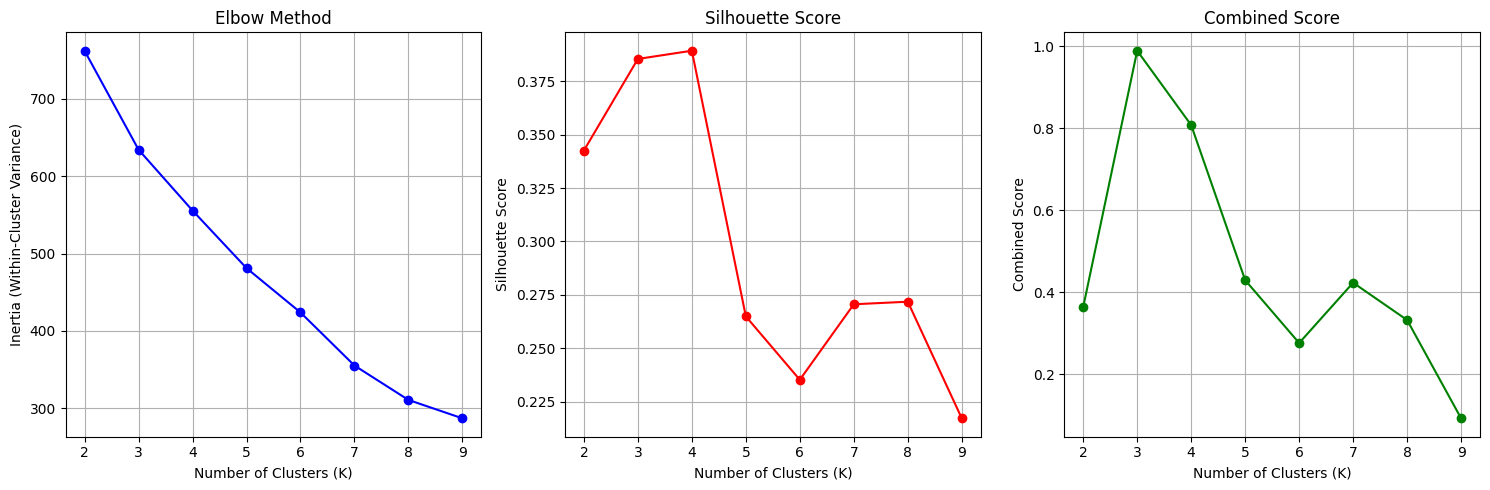


Optimal number of clusters (K): 3


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in a variable called 'data'
# If your data isn't already scaled, you should scale it first:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data)

# Replace 'scaled_user_features' with your actual scaled data variable name
data = scaled_user_features

# Calculate both inertia (within-cluster variance) and silhouette scores
inertias = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    # Create and fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)
    
    # Calculate inertia (within-cluster variance)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (measure of cluster separation)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"K={k}, Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.4f}")

# Calculate inertia differences (to find the "elbow")
inertia_diffs = np.diff(inertias)
inertia_diffs = np.append(0, inertia_diffs)  # Add 0 for K=2 to align with k_range

# Create a combined metric: We want high silhouette score and large inertia drop
# Normalize both metrics to 0-1 range
norm_silhouette = (silhouette_scores - min(silhouette_scores)) / (max(silhouette_scores) - min(silhouette_scores) + 1e-10)
norm_inertia_diffs = abs(inertia_diffs) / (max(abs(inertia_diffs)) + 1e-10)
combined_score = 0.5 * norm_silhouette + 0.5 * norm_inertia_diffs

# Find optimal K
optimal_k_idx = np.argmax(combined_score)
optimal_k = list(k_range)[optimal_k_idx]

# Visualize the results
plt.figure(figsize=(15, 5))

# Plot 1: Elbow Method
plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Variance)')
plt.xticks(k_range)
plt.grid(True)

# Plot 2: Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)

# Plot 3: Combined Score
plt.subplot(1, 3, 3)
plt.plot(k_range, combined_score, 'go-')
plt.title('Combined Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Combined Score')
plt.xticks(k_range)
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nOptimal number of clusters (K): {optimal_k}")

# Create the final model with optimal K
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_kmeans.fit(data)

# Get the final cluster assignments
cluster_labels = final_kmeans.labels_


In [22]:
clusters = final_kmeans.predict(scaled_user_features)
clustered_users = pd.DataFrame(user_features[["user_id"]], columns=["user_id"])
clustered_users["cluster"] = clusters
clustered_users.head()

,user_id,cluster
0,U000001,1
1,U000009,2
2,U000011,0
3,U000014,1
4,U000017,1


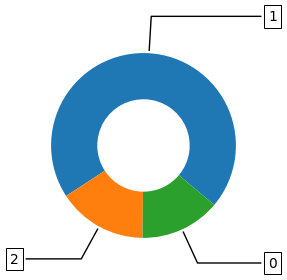

In [23]:
import matplotlib.pyplot as plt
import numpy as np

cluesters_counts = clustered_users["cluster"].value_counts().to_dict()

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(cluesters_counts.values(), wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(list(cluesters_counts.keys())[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.show()


#### Explainability

In [24]:
centroids = final_kmeans.cluster_centers_
original_centroids = standard_scaler.inverse_transform(centroids)
original_centroids_df = pd.DataFrame(original_centroids, columns=complete_user_features.columns)

original_centroids_df.head()






,total_rides,avg_distance_km,max_distance_km,avg_pickup_latitude,avg_pickup_longitude,avg_dropoff_latitude,avg_dropoff_longitude,most_common_hour,most_common_day_of_week,weekend_ride_ratio,to_event_ratio,from_event_ratio,most_common_event,distance_variance,hour_variance,age,gender,signup_date
0,3.111111,9.238866,10.701886,40.443271,-3.662745,40.492724,-3.576430,7.000000,2.111111,0.0,0.0,0.000000e+00,0.777778,19.312413,0.212963,39.111111,1.222222,2022.777778
1,2.444444,1.532942,1.886804,40.423806,-3.691998,40.422537,-3.692856,7.577778,2.000000,0.0,0.0,8.326673e-17,0.066667,0.772048,2.424444,41.488889,0.577778,2022.977778
2,2.200000,10.392456,12.812846,40.479888,-3.598964,40.424446,-3.694054,7.100000,2.000000,0.0,0.0,8.083333e-01,1.100000,20.219409,-0.250000,44.000000,0.600000,2022.500000


Cluster 0:
- Males
- Ride the Most
- Very long Rides
- Love Events, Specially Concerts

Cluster 1:
- Somewhat Frequent Riders
- Very Short Rides
- Not very into events

Cluster 2:
- Older Clients
- Ride the least frequently
- Take the longest rides
- Somewhat into events, but middle ground between Concerts & Sports

### Creating Outlier Detector

#### Preparing Data

In [26]:
rides_outlier_subset = rides_with_event_info[["timestamp","pickup_latitude",
                       "pickup_longitude","dropoff_latitude","dropoff_longitude",
                       "traffic_level","distance_km","estimated_duration_minutes",
                       "actual_duration_minutes","estimated_delay_minutes",
                       "driver_speed_kmh"]]
rides_outlier_subset["month"] = rides_outlier_subset["timestamp"].dt.month
rides_outlier_subset["day"] = rides_outlier_subset["timestamp"].dt.day
rides_outlier_subset["hour"] = rides_outlier_subset["timestamp"].dt.hour
rides_outlier_subset["day_of_week"] = rides_outlier_subset["timestamp"].dt.dayofweek
rides_outlier_subset.drop(columns=["timestamp"], inplace=True)
rides_outlier_subset.head()

C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\1903024466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_outlier_subset["month"] = rides_outlier_subset["timestamp"].dt.month
C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\1903024466.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_outlier_subset["day"] = rides_outlier_subset["timestamp"].dt.day
C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\1903024466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,traffic_level,distance_km,estimated_duration_minutes,actual_duration_minutes,estimated_delay_minutes,driver_speed_kmh,month,day,hour,day_of_week
0,40.408460,-3.702370,40.498333,-3.567498,HIGH,15.168999,37,70.0,26,0.000000,1,1,8,2
1,40.461591,-3.676449,40.461646,-3.676667,SEVERE,0.019388,12,NaN,31,0.000000,1,1,7,2
2,40.416757,-3.703749,40.416664,-3.703755,SEVERE,0.010333,10,NaN,46,NaN,1,1,7,2
3,40.416757,-3.703749,40.416664,-3.703755,SEVERE,0.010333,10,NaN,46,38.600246,1,1,7,2
4,40.416757,-3.703749,40.416664,-3.703755,SEVERE,0.010333,10,0.0,46,0.000000,1,1,7,2


In [27]:
# Get unique traffic levels
unique_traffic_levels = rides_outlier_subset["traffic_level"].unique()

# Create a mapping dictionary with an index for each unique traffic level
traffic_levels = {}
for i, level in enumerate(unique_traffic_levels):
    traffic_levels[level] = i

# Apply the mapping function
rides_outlier_subset["traffic_level"] = rides_outlier_subset["traffic_level"].apply(map_level, args=(traffic_levels,))

# Alternatively, you can use the map function with a default value
# rides_outlier_subset["traffic_level"] = rides_outlier_subset["traffic_level"].map(
#     traffic_levels).fillna(len(traffic_levels)).astype(int)

rides_outlier_subset.head()


C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\3213754606.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_outlier_subset["traffic_level"] = rides_outlier_subset["traffic_level"].apply(map_level, args=(traffic_levels,))


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,traffic_level,distance_km,estimated_duration_minutes,actual_duration_minutes,estimated_delay_minutes,driver_speed_kmh,month,day,hour,day_of_week
0,40.408460,-3.702370,40.498333,-3.567498,0,15.168999,37,70.0,26,0.000000,1,1,8,2
1,40.461591,-3.676449,40.461646,-3.676667,1,0.019388,12,NaN,31,0.000000,1,1,7,2
2,40.416757,-3.703749,40.416664,-3.703755,1,0.010333,10,NaN,46,NaN,1,1,7,2
3,40.416757,-3.703749,40.416664,-3.703755,1,0.010333,10,NaN,46,38.600246,1,1,7,2
4,40.416757,-3.703749,40.416664,-3.703755,1,0.010333,10,0.0,46,0.000000,1,1,7,2


In [28]:
rides_outlier_subset = rides_outlier_subset.fillna(-100)

#### Fitting & Testing

In [29]:
standard_scaler_outlier = StandardScaler()
standard_scaler_outlier = standard_scaler_outlier.fit_transform(rides_outlier_subset)
scaled_rides_outlier = pd.DataFrame(standard_scaler_outlier, columns=rides_outlier_subset.columns)
scaled_rides_outlier.head()


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,traffic_level,distance_km,estimated_duration_minutes,actual_duration_minutes,estimated_delay_minutes,driver_speed_kmh,month,day,hour,day_of_week
0,-0.815339,-0.566009,1.982608,2.048699,-2.405351,2.108318,1.769516,1.974114,-1.554299,0.444984,0.0,-0.112509,0.156334,-0.112509
1,0.921502,-0.009817,0.823819,-0.108846,0.267261,-0.738035,-0.530797,-0.840137,-1.111163,0.444984,0.0,-0.112509,-0.354145,-0.112509
2,-0.544110,-0.595598,-0.596949,-0.644210,0.267261,-0.739737,-0.714822,-0.840137,0.218244,-1.297554,0.0,-0.112509,-0.354145,-0.112509
3,-0.544110,-0.595598,-0.596949,-0.644210,0.267261,-0.739737,-0.714822,-0.840137,0.218244,1.117608,0.0,-0.112509,-0.354145,-0.112509
4,-0.544110,-0.595598,-0.596949,-0.644210,0.267261,-0.739737,-0.714822,0.815305,0.218244,0.444984,0.0,-0.112509,-0.354145,-0.112509


In [30]:
from sklearn.svm import OneClassSVM
from joblib import dump, load

one_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
one_svm.fit(rides_outlier_subset)

OneClassSVM(gamma=0.01, nu=0.01)

In [31]:
scores = one_svm.decision_function(rides_outlier_subset)
total_outliers = 0
for i in range(len(scores)):
    if scores[i] < 0:
        total_outliers += 1
        print(f'{i}: {scores[i]}')
print(f"Outliers Proportion: {total_outliers/len(scores)}")

0: -2.6663940888495274e-05
1: -0.00013556303586734209
3: -0.00022908224618664597
7: -0.0002262920794812856
10: -7.838349865076782e-05
11: -0.00023204953891735325
12: -0.00037189125163591963
13: -0.00019688728986916315
14: -0.00016342540298795727
15: -1.725765638140031e-05
16: -1.725765638140031e-05
19: -0.00023204973967106551
23: -0.0002987217945280285
26: -0.00015995894620558088
35: -2.735515548898948e-05
40: -0.00010225277583832126
41: -9.057544145045504e-05
42: -0.00027987809479024933
43: -7.587086919366715e-05
46: -0.00026100277191999643
48: -2.7758037205609376e-05
51: -2.4183899703843215e-05
52: -0.00040745463271467386
54: -0.00039390276519519346
59: -0.0003534265728022193
64: -9.677001495524834e-05
65: -0.0002197742167041744
75: -0.00015793569857786016
76: -0.00012134056857493469
84: -0.00022796297007889738
86: -8.45724980500645e-06
88: -3.190970991046732e-05
90: -5.346559880310686e-05
96: -4.193452988013324e-05
100: -3.088762005452189e-05
101: -4.2414664078255226e-05
102: -4.241

In [ ]:
dump(one_svm, 'oneclass_svm_model.joblib')

loaded_model = load('oneclass_svm_model.joblib')

predictions = loaded_model.predict(user_features)